In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('data/', 'train.csv')
sub_data_path = join('data/', 'test.csv')

# 1. 데이터 확인

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [20]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

## feature engineering

### 상관계수 확인

In [21]:
# 연도, 월만 남기기
data['date'] = data['date'].apply(lambda x : x[:6]).astype(int)
sub['date'] = sub['date'].apply(lambda x : x[:6]).astype(int)

<AxesSubplot:>

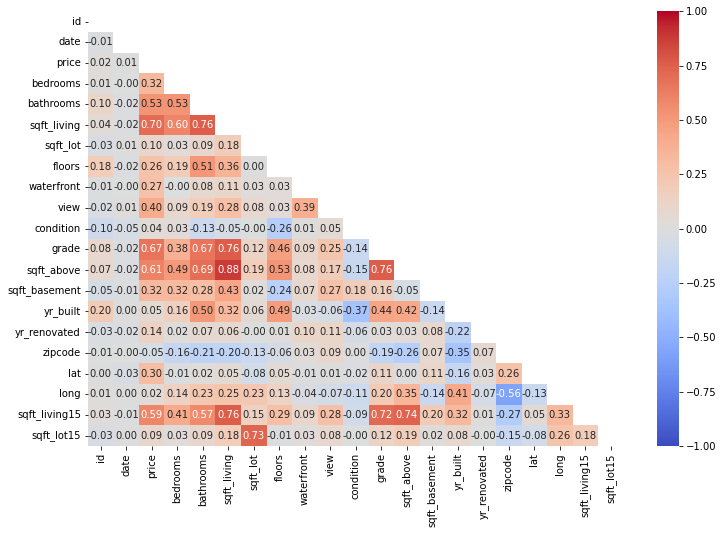

In [5]:
cm = data.corr()
matrix = np.triu(cm) # mask
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix, ax=ax)

id, date, sqft_lot, condition, yr_built, zipcode, long, sqft_lot15는 상관계수 0.1이하

### 타겟 데이터 분리

In [22]:
if 'price' in data.columns:
    y = data['price']
    del data['price']

### 타겟 데이터와의 관계 확인
상관계수가 낮은 feature와 price 간의 관계 확인

In [ ]:
cols = ['date', 'sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15']

fig, ax = plt.subplots(4, 2, figsize=(12, 30)) 

count = 0
for row in range(4):
    for col in range(2):
        sns.scatterplot(data[cols[count]], y, ax=ax[row][col])
        ax[row][col].set_title(cols[count], fontsize=15)
        count += 1
        if count == 7 :
            break

### feature importance 확인
Ridge 모델 활용
[reference](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

In [ ]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(data, y)
importance = np.abs(ridge.coef_)
fig = plt.figure(figsize=(20, 8))
plt.bar(height=importance, x=data.columns)
plt.title("Feature importances via coefficients")
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-18] + 0.01
sfm = SelectFromModel(ridge, threshold=threshold).fit(data, y)
to_delete = data.columns.drop(data.columns[sfm.get_support()])
print(f"Features selected by SelectFromModel: {to_delete}")

#### 전처리를 위해 train, test 데이터 합치기

In [23]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

# 2. 전처리 

## feature selection

### 열 하나씩 지워보기
효율적이지 않음 -> Rigde 모델 활용함

In [ ]:
cols = ['date', 'sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15']
'''
if 'date' in data.columns:
    del data['date']
if 'sqft_lot' in data.columns:
    del data['sqft_lot']
if 'condition' in data.columns:
    del data['condition']
if 'yr_built' in data.columns:
    del data['yr_built']
if 'zipcode' in data.columns:
    del data['zipcode']
if 'long' in data.columns:
    del data['long']
if 'sqft_lot15' in data.columns:
    del data['sqft_lot15']
'''

1. 'date'열 삭제
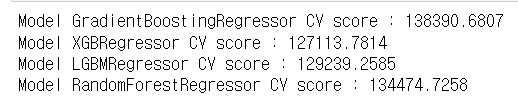
2. 'sqft_lot'
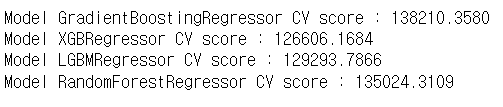
3. 'condition'
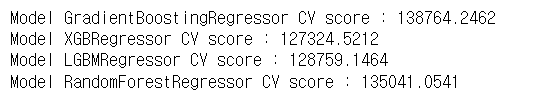
4. 'yr_built'
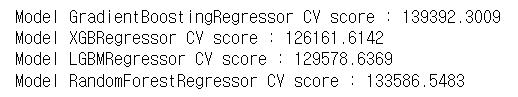
5. 'zipcode'
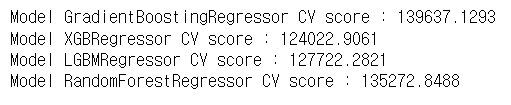
6. 'long'
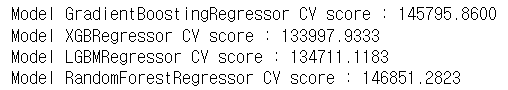
7. 'sqft_lot15'
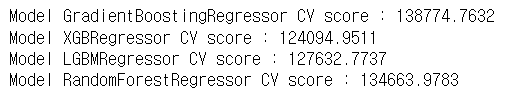
> 'zipcode', 'sqft_lot15' 빼서 xgb에 넣으면 좋을 듯

### feature importance 높은 feature만 남기기

In [ ]:
'''
for feature in to_delete:
    if feature in data.columns:
        del data[feature]
'''

중요도 높은 상위 n개 feature로 cv 수행한 결과

1. 상위 10개
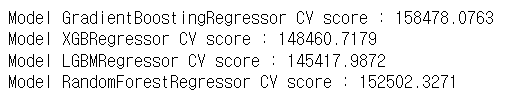
2. 상위 15개
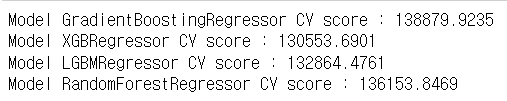
3. 상위 17개
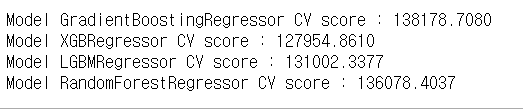

feature selection 안 했을 때
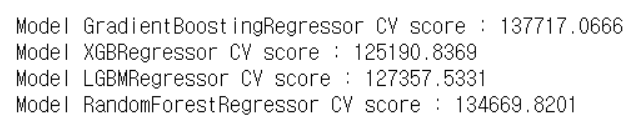

> feature selection 효과 없는 듯

### id, date 변수 정리

In [24]:
# id는 예측에 필요 없으므로 데이터셋에서 삭제
if 'id' in data.columns:
    sub_id = data['id'][train_len:]
    del data['id']

In [ ]:
data.head()

### 결측치 확인

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

결측치 없음

### 이상치 확인

In [ ]:
def plotOutlier(df):
  nrows=int(len(df.columns)/2)
  fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(15, nrows*3))
  axs = axs.flatten()

  for i in range(1, len(df.columns)):
    sns.boxplot(x=df.columns[i], data=df, ax=axs[i-1], orient='v')

  plt.suptitle('Distributions', y=1.02, fontsize=16)
  plt.tight_layout()
  plt.show()

plotOutlier(data)

bedrooms, bathrooms, condition, zipcode, lat 확인해 볼 필요 있음

In [ ]:
def CalcIQR(data, cols):
    results = {}
    for col in cols:
        Q3, Q1 = np.percentile(data[col], [75 ,25])
        IQR = Q3 - Q1
        result = data[(Q1-1.5*IQR > data[col])|(Q3+1.5*IQR < data[col])]
        print(col, ": ", len(result))
        results[col] = result[col].unique()
    return results
        
cols = ['bedrooms', 'bathrooms', 'condition', 'zipcode', 'lat']
drop_df = CalcIQR(data, cols)
drop_df

> bedrooms: 1 혹은 6 많고 그 외의 더 큰 수, condition: 1, zipcode: 결측치 있음, lat: 47.15근처의 값 2개

### 이상치 처리(추후 진행)

### 각 변수들의 분포 확인

In [ ]:
def plotDistribution(data, cols):
    num_cols = len(cols)
    nrows = int(np.ceil(num_cols/2))
    
    fig, ax = plt.subplots(nrows, 2, figsize=(12, int(num_cols*4))) 

    count = 0
    for row in range(nrows):
        for col in range(2):
            sns.kdeplot(data=data[cols[count]], ax=ax[row][col])
            ax[row][col].set_title(cols[count], fontsize=15)
            count += 1
            if count == num_cols :
                return
            
plotDistribution(data, data.columns)

In [ ]:
sns.kdeplot(y)

#### 로그 변환
price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 한쪽으로 치우침

In [ ]:
y = np.log1p(y)    # 'price' 로그 변환

In [25]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    if c in data.columns:
        data[c] = np.log1p(data[c].values)


> 미미한 성능 차이가 있음
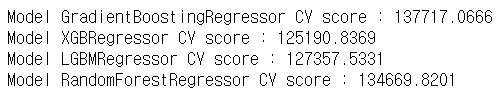

### 데이터셋 나누기
훈련용, 제출용으로 나눔

In [26]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

### 정규화
train 데이터 기준으로 정규화 해야 하므로 데이터셋 분리 후에 정규화 시행

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit_transform(x)
scaler.transform(sub)

> 정규화 하든 안 하든 성능 차이 없음

## 3. 모델링

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

> **모델 선택 이유** : baseline에 있던 네 가지 모델 이외에도 추가해보고 싶어 elasticnet, sgdregressor, svr로도 cross validation을 진행해봤는데 원래의 네 가지 모델보다 성능이 확연히 떨어짐. 따라서 기본 네 가지 모델의 하이퍼 파라미터 튜닝에 집중하기로 함
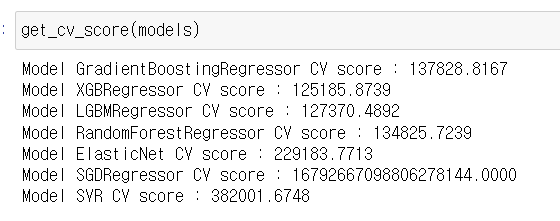

### Cross Validation

In [29]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

scoring = make_scorer(rmse, greater_is_better=False)

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        score = cross_val_score(m, x.values, y, scoring = scoring)
        score = -1*score    # greater_is_better 옵션은 -1을 곱함
        print("Model {} CV score : {:.4f}".format(m.__class__.__name__, np.mean(score), 
                                             kf=kfold))

> **metrics 선정 이유** : 대회 채점 기준이 rmse라 cv 단계에서부터 rmse를 확인하고 싶었음

In [30]:
get_cv_score(models)

Model GradientBoostingRegressor CV score : 137717.0666
Model XGBRegressor CV score : 125190.8369
Model LGBMRegressor CV score : 127357.5331
Model RandomForestRegressor CV score : 134669.8201


## 4. 모델 튜닝

### 하이퍼 파라미터 튜닝

###### GradientBoostingRegressor
1. `n_estimators`: Number of boosting stages to be run.
2. `learning_rate`: Shrinks the contribution of each tree.
3. `max_depth`: Maximum depth of the individual regression estimators.

###### XGBRegressor
1. `n_estimators`: Number of gradient boosted trees.
2. `learning_rate`: Step size shrinkage used to prevent overfitting.
3. `max_depth`: Maximum depth of a tree.
4. `subsample`: Fraction of samples used for fitting the individual trees.

###### LGBMRegressor 
1. `n_estimators`: Number of boosting iterations.
2. `learning_rate`: Shrinks the contribution of each tree.
3. `num_leaves`: Number of leaves in one tree.
4. `max_depth`: Maximum depth of the tree.

###### RandomForestRegressor
1. `n_estimators`: Number of trees in the forest.
2. `max_depth`: Maximum depth of the tree.
3. `min_samples_split`: Minimum number of samples required to split an internal node.
4. `max_features`: Number of features to consider when looking for the best split.

#### 그리드 서치

In [31]:
from sklearn.model_selection import GridSearchCV

def myGridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                        scoring=scoring,
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(x, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = -1*score
    results = results.sort_values(by='score')
    
    display(results)

    return grid_model.best_estimator_

**XGBRegressor 하이퍼 파라미터 튜닝**

In [34]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4, 5],
}

xgboost = myGridSearch(xgboost, x, y, xgb_param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,learning_rate,max_depth,n_estimators,score
9,0.2,4,200,120120.710235
11,0.2,5,200,120339.884048
5,0.1,5,200,121294.001552
10,0.2,5,100,121490.820841
3,0.1,4,200,121890.284690
8,0.2,4,100,123267.823202
4,0.1,5,100,124953.702690
7,0.2,3,200,126632.946065
2,0.1,4,100,127366.703684
1,0.1,3,200,129430.022180


[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   1.3s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.1s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=30; total time=   0.6s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=30; total time=   0.7s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=50; total time=   0.9s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   1.2s
[CV] END ....learning_rate=0.2, max_depth=4, n_estimators=30; total time=   0.4s
[CV] END ....learning_rate=0.2, max_depth=4, n_estimators=50; total time=   0.8s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   1.0s
[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=30; total time=   0.6s
[CV] END ....learning_rate=0

[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=30; total time=   0.4s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   1.1s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=30; total time=   0.7s
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.0s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=30; total time=   0.5s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=30; total time=   0.7s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=50; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   1.5s
[CV] END ....learning_rate=0.2, max_depth=4, n_estimators=50; total time=   0.7s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time=   1.2s
[CV] END ....learning_rate=0

**LGBMRegressor 하이퍼 파라미터 튜닝**

In [32]:
lgbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [4, 5, 6]
}

lightgbm = myGridSearch(lightgbm, x, y, lgbm_param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score
23,0.3,5,100,127709.263436
26,0.3,6,100,129071.488969
14,0.2,5,100,129108.314071
8,0.1,6,100,129658.766304
17,0.2,6,100,130143.764209
20,0.3,4,100,130232.291658
11,0.2,4,100,130334.281660
5,0.1,5,100,131217.264872
25,0.3,6,50,131356.758470
16,0.2,6,50,132285.925263


**RandomForestRegressor 하이퍼 파라미터 튜닝**

In [33]:
rdf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
}

rdforest = myGridSearch(rdforest, x, y, rdf_param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score
5,30,200,133949.198536
2,20,100,134065.490318
4,30,100,134159.495652
3,20,200,134321.443063
1,10,200,139616.943215
0,10,100,140072.824903


#### 랜덤 서치

In [37]:
from sklearn.model_selection import RandomizedSearchCV

def myRandomSearch(model, x, y, param_distributions, verbose=2, n_jobs=-1):
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions,
                                       scoring=scoring,
                                       cv=5, verbose=verbose, n_jobs=n_jobs, n_iter=8)

    random_search.fit(x, y)
    params = random_search.cv_results_['params']
    score = random_search.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = -1*score
    results = results.sort_values(by='score')
    
    display(results)

    return random_search.best_estimator_


**GradientBoostingRegressor 하이퍼 파라미터 튜닝**

In [38]:
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
}

gboost = myRandomSearch(gboost, x, y, param_dist)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,n_estimators,max_depth,learning_rate,score
4,200,5,0.1,121634.831960
5,200,5,0.2,122703.871169
3,100,5,0.1,124811.604936
1,150,4,0.1,125515.274989
0,150,3,0.3,126113.044992
6,50,4,0.2,129949.197612
7,50,5,0.1,130808.549189
2,100,3,0.1,137717.066636


In [ ]:
gboost = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=random_state)
xgboost = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.2, random_state=random_state)
lightgbm = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.3, random_state=random_state)
rdforest = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=random_state)

### Blending

In [39]:
models = [gboost, xgboost, lightgbm, rdforest]

def AveragingBlending(models, x, y, sub):   
    # 예측값 산출
    predictions = np.column_stack([
        model.predict(sub) for model in models
    ])
    
    # 예측값 평균
    return np.mean(predictions, axis=1)

## 결과 제출

In [40]:
predictions = AveragingBlending(models, x, y, sub)

In [41]:
sub = pd.DataFrame(data={'id':sub_id,'price':predictions})

In [42]:
sub.to_csv('submission.csv', index=False)

[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=150; total time=   9.4s
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=150; total time=   9.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=  12.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=  12.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=  12.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   6.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  10.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  10.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  10.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  20.4s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  20.3s
[CV] END ...learning_rate=0.